# Radix2w Point Multiplication in Elliptic Curve Cryptography
## Radix-2 Windowing-Based Scalar Multiplication in Curve K163


One approach to performing point multiplication is the radix-2 windowing-based scalar multiplication algorithm. This algorithm involves breaking the scalar into several bit-windows and performing precomputations on the points corresponding to each bit-window. Then, during the actual multiplication, the algorithm uses these precomputed points and a sliding window to efficiently compute the final result.

This implementation is demonstrated on curve K163, a popular elliptic curve used in various cryptographic protocols.

The Point Multiplication module is created on the programmable logic of the PYNQ Z1 board and further imported to PYNQ framework running on the processing system of the same board for implemenation and control of the elliptic curve point muliplication hardware module(ECPM)


In [39]:
from pynq import Overlay
ol = Overlay('/home/xilinx/pynq/SM/design.bit')
from pynq import allocate
import numpy as np 
import time
ECPM = ol.scalarMult_0

## Registers of the Scalar Multiplicatoin IP

The registers that we need to write values to:

* CTRL - the control register
* k_1 - the lower 32-bits of the start address for the memory range the IP will access to write get the value of the scalar
* x_o_1 - the lower 32-bits of the start address for the memory range the IP will access to write the value of the x coordinate 
* y_o_1 - the lower 32-bits of the start address for the memory range the IP will access to write the value of the y coordinate

In [40]:
ECPM.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  k_1 = Register(k=write-only),
  k_2 = Register(k=write-only),
  x_o_1 = Register(x_o=write-only),
  x_o_2 = Register(x_o=write-only),
  y_o_1 = Register(y_o=write-only),
  y_o_2 = Register(y_o=write-only),
  SM = Register(SM=write-only)
}

## Allocating memory spcaes for scalar k, coordinate x, and coordinate y

The start address for the memory in which these parameters are written will be passed to the ECPM IP, by starting the the computation on IP using the start bit of the control register, the IP will read data from this memory and write results back to the x and y coordinate memory locations. 

In [41]:
k_buffer = allocate(shape=(6,), dtype=np.uint32)
x_buffer = allocate(shape=(6,),dtype=np.uint32)
y_buffer = allocate(shape=(6,),dtype=np.uint32)
K_x = np.array([ 0x5c94eee8, 0xde4e6d5e, 0xaa07d793, 0x7bbc11ac, 0xfe13c053, 0x00000002], dtype=np.uint32)
K_y = np.array([0xccdaa3d9, 0x0536d538, 0x321f2e80, 0x5d38ff58, 0x89070fb0, 0x00000002], dtype=np.uint32)
B_x = np.array([0xE8343E36, 0xD4994637, 0xA0991168, 0x86A2D57E, 0xF0EBA162, 0x03],dtype = np.uint32)
B_y = np.array([0x797324F1, 0xB11C5C0C, 0xA2CDD545, 0x71A0094F, 0xD51FBC6C, 0x0],dtype = np.uint32)

k1 = np.array([0x00000008, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
k2 = np.array([0xFFFFFFFF, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
k3 = np.array([0xFFFFFFFF, 0xFFFFFFFF, 0xFFFFFFFF, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
k4 = np.array([0x0FFF8000, 0xF0003E00, 0xE0001FFF, 0xFFF00FFF, 0x0FFE0FFF, 0x00000002], dtype=np.uint32)
k5 = np.array([0xFF8007FF, 0xFFFF807F,0x000003FF, 0x0007C000, 0xFFF07FFE,0x3],dtype = np.uint32)
k5 = np.array([0xFF8007FF, 0xFFFF807F,0x000003FF, 0x0007C000, 0xFFF07FFE,0x3],dtype = np.uint32)
k6 = np.array([0xFFF80000, 0x010001FF,0xFFE08000, 0x07FFF1FF, 0xFFFFFE00,0x3],dtype = np.uint32)

two_key = np.array([0x00000002, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
four_key = np.array([0x00000004, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
six_key = np.array([0x00000006, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
eight_key = np.array([0x00000008, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
nine_key = np.array([0x00000009, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
B_key = np.array([0x99F8A5EE, 0xA2E0CC0D,0x00020108, 0x00000000, 0x00000000,0x4],dtype = np.uint32)
A_key = np.array([0xFF8007FF, 0xFFFF807F,0x000003FF, 0x0007C000, 0xFFF07FFE,0x3],dtype = np.uint32)
np.copyto(x_buffer, K_x)
np.copyto(y_buffer, K_y)

## Passing the values k,x and y to ECPM IP

Writing the values of the memory address of scalar k, coordinate x, and coordinate y


In [42]:
ECPM.register_map.k_1 = k_buffer.physical_address
ECPM.register_map.x_o_1 = x_buffer.physical_address
ECPM.register_map.y_o_1 = y_buffer.physical_address

## Performing Multiple Point Multiplication Operations

In [43]:
def Radix2w_point_multiplication(key):
    np.copyto(k_buffer, key)
    np.copyto(x_buffer, K_x)
    np.copyto(y_buffer, K_y)
    ECPM.register_map.CTRL.AP_START = 1

# Wait for IP to finish
    while not ECPM.register_map.CTRL.AP_DONE:
        pass
    hex_string = "k = "
    print("k =",k_buffer[0])
    hex_string = "x = "
    for i in range(len(x_buffer)-1, -1, -1):
        hex_string += "{:08X}".format(x_buffer[i])
    print(hex_string)
    hex_string = "y = "
    for i in range(len(y_buffer)-1, -1, -1):
        hex_string += "{:08X}".format(y_buffer[i])
    print(hex_string)
Radix2w_point_multiplication(two_key)
Radix2w_point_multiplication(four_key)
Radix2w_point_multiplication(six_key)
Radix2w_point_multiplication(eight_key)

k = 2
x = 00000000CB5CA2738FE300AACFB00B42A77B828D8A5C41EB
y = 0000000229C79E9AB85F90ACD3D5FA3A696664515EFEFA6B
k = 4
x = 00000000BA8C7E6E2523EF94CBC1E56FACFEDE24F3F91578
y = 0000000510F96CBC41CF3BDFA0157E9E8FEE2C605791DB0D
k = 6
x = 0000000765470BC65E9AB8C40B297C983B1000BCF021426E
y = 00000000A58BA7C589659F870A0CB121F76D61122D8741B6
k = 8
x = 00000003A11E19CC4C0B15CD4C7D5A5CF2D5A8C383287DA8
y = 0000000204041306C461A237C8E5D1644D0ACA7D738A1257


For referencing Point Multiplication values, the following link can be visited: http://point-at-infinity.org/ecc/nisttv

## Execution Time Analysis

The implemented ECPM hardware IP can work with two different algorithm for point muliplication, the first is the Radix2w method, and the second is the binary method, based on the value written the axi lite interface register SM, a certain algorithm is chosen, we perform PM operations for number of different scalars using both algorithms, comparision between the two proves the superiority of our developed Radix2w module in term of execution time with around 28% enhancement

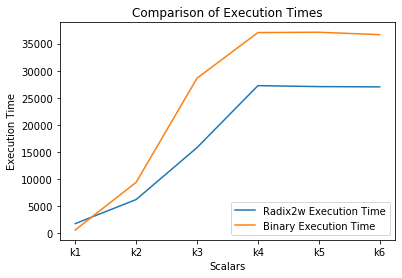

In [44]:
import matplotlib.pyplot as plt
Radix2w_execution_time = np.zeros(6)
Binary_execution_time = np.zeros(6)
scalars=[k1,k2,k3,k4,k5,k6]
scalars_def = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6']
def point_multiplication(SM,timing):
    for i in range(6):
        np.copyto(k_buffer,scalars[i])
        np.copyto(x_buffer, K_x)
        np.copyto(y_buffer, K_y)
        ECPM.register_map.SM=SM
        start = time.perf_counter()
        ECPM.register_map.CTRL.AP_START = 1
        # Wait for IP to finish
        while not ECPM.register_map.CTRL.AP_DONE:
            pass
        stop = time.perf_counter()
        extime = (stop - start) * 1e6
        timing[i] = extime
point_multiplication(0,Binary_execution_time)
point_multiplication(1,Radix2w_execution_time)
x = np.arange(len(scalars_def))

# Plot the arrays
plt.plot(x, Radix2w_execution_time, label='Radix2w Execution Time')
plt.plot(x, Binary_execution_time, label='Binary Execution Time')

# Set labels and title
plt.xlabel('Scalars')
plt.ylabel('Execution Time')
plt.title('Comparison of Execution Times')

# Set x-axis tick labels
plt.xticks(x, scalars_def)

# Add legend
plt.legend()

# Show the plot
plt.show()

# Point Multiplication in Elliptic Curve Diffie-Hellman Key Exchange
## Radix-2 Windowing-Based Scalar Multiplication in Curve K163

In elliptic curve cryptography, point multiplication is a fundamental operation used in various cryptographic protocols such as Elliptic Curve Diffie-Hellman (ECDH).

In [45]:
def ecdh(a_key,b_key):
    # Alice's variables
    alice_pb_x = np.empty(6, dtype=np.uint32)
    alice_pb_y = np.empty(6, dtype=np.uint32)
    shared_alice_x = np.empty(6, dtype=np.uint32)
    shared_alice_y = np.empty(6, dtype=np.uint32)

    # Bob's variables
    bob_pb_x = np.empty(6, dtype=np.uint32)
    bob_pb_y = np.empty(6, dtype=np.uint32)
    shared_bob_x = np.empty(6, dtype=np.uint32)
    shared_bob_y = np.empty(6, dtype=np.uint32)
    #alice public key generation
    k_buffer=a_key
    x_buffer= K_x
    y_buffer = K_y
    ECPM.register_map.CTRL.AP_START =1
    np.copyto(alice_pb_x, x_buffer)
    np.copyto(alice_pb_y, y_buffer)
    while not ECPM.register_map.CTRL.AP_DONE:
        pass
    #bob public key generation
    k_buffer=b_key
    x_buffer= K_x
    y_buffer = K_y
    ECPM.register_map.CTRL.AP_START =1
    np.copyto(bob_pb_x, x_buffer)
    np.copyto(bob_pb_y, y_buffer)
    while not ECPM.register_map.CTRL.AP_DONE:
        pass
    # exchange alice
    k_buffer=a_key
    x_buffer= bob_pb_x
    y_buffer = bob_pb_y
    ECPM.register_map.CTRL.AP_START =1
    np.copyto(shared_alice_x, x_buffer)
    np.copyto(shared_alice_y, y_buffer)
    while not ECPM.register_map.CTRL.AP_DONE:
        pass
    # exchange bob
    k_buffer=b_key
    x_buffer= alice_pb_x
    y_buffer = alice_pb_y
    ECPM.register_map.CTRL.AP_START =1
    np.copyto(shared_bob_x, x_buffer)
    np.copyto(shared_bob_y, y_buffer)
    while not ECPM.register_map.CTRL.AP_DONE:
        pass
    if(np.all(shared_bob_x==shared_alice_x) and np.all(shared_bob_y==shared_alice_y)):
        print("Key exchange successful!")
    else:
        print("Key exchange failed")
ecdh(A_key, B_key)

Key exchange successful!
